In [1]:
#Auto reload
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd

validation_losses = []
# Load logged losses
with open("Finetune/validation_losses_convirt.json", "r") as f:
    for line in f:
        validation_losses.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(validation_losses)

df


FileNotFoundError: [Errno 2] No such file or directory: 'Finetune/validation_losses_convirt.json'

In [25]:
# Identify problematic batches
sorted_batches = df.sort_values(by="loss", ascending=False)
sorted_batches

batch_idx      loss                                              preds  \
0             0  0.810668  [1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, ...   
1             1  0.794019  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, ...   
673          51  0.598908  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
983          51  0.572013  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
1169         51  0.568532  [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
...         ...       ...                                                ...   
822          14  0.227242  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
1251          9  0.224308  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...   
1313          9  0.224288  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...   
1132         14  0.218355  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
36           34  0.195179  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                 labels  
0     [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...  
1     [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
673   [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...  
983   [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...  
1169  [1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, ...  
...                                                 ...  
822   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
1251  [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
1313  [0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
1132  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...  
36    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...  

[1428 rows x 4 columns]

In [28]:
sorted_batches.to_excel('validation_output.xlsx', index=False)

In [29]:
preds = sorted_batches.iloc[2]['preds']
labels = sorted_batches.iloc[2]['labels']

different_indices = [i for i, (p, l) in enumerate(zip(preds, labels)) if p != l]
different_indices

[5, 6, 12, 17, 18, 22, 26, 31, 36, 38, 42, 43, 45, 48, 49, 50, 56, 58, 61]

In [15]:
preds = sorted_batches.iloc[310]['preds']
labels = sorted_batches.iloc[310]['labels']

different_indices = [i for i, (p, l) in enumerate(zip(preds, labels)) if p != l]
different_indices

[7, 28, 31, 46, 52, 63]

## Saliency Maps

In [12]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/chexpert.yaml')

checkpoint_path = checkpoint_path
checkpoint = torch.load(checkpoint_path)
model = FinetuneClassifier(config)
model.load_state_dict(checkpoint['state_dict'])

Loading configuration from: ../configs/chexpert.yaml


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [10]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import (EarlyStopping, LearningRateMonitor,
                                         ModelCheckpoint)
from pytorch_lightning.loggers import WandbLogger
from methods.cls_model import FinetuneClassifier
import torch
import yaml
import os
import datetime
import argparse
from pytorch_lightning import LightningModule, seed_everything
from datasets.cls_dataset import RSNAImageClsDataset, ChexPertImageClsDataset
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms
from dateutil import tz
import warnings

In [13]:
def load_config(config_path):
    print(f"Loading configuration from: {config_path}")
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

In [16]:
import argparse
#checkpoint_path = 'path/to/your/saved_checkpoint.ckpt'

#checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'
checkpoint_path = "/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/pretrained/medclip-vit/pytorch_model.bin"


def parse_args():
    parser = argparse.ArgumentParser(description='PyTorch Lightning Training')
    parser.add_argument("--dataset", type=str, default="rsna", help="Dataset to use: chexpert, rsna")
    parser.add_argument('--gpus', type=int, default=None, help='Number of GPUs to use (default: 1)')
    parser.add_argument('--config', type=str, default='/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/VLP-Seminar/configs/rsna.yaml', help='Path to config file:chexpert.yaml, rsna.yaml')
    parser.add_argument("--batch_size", type=int, default=64, help="Batch size")
    parser.add_argument("--num_workers", type=int, default=16, help="Number of workers for dataloader")
    parser.add_argument("--data_pct", type=float, default=0.1, help="Percentage of data to use")
    parser.add_argument("--max_epochs", type=int, default=50, help="Number of epochs to train")
    parser.add_argument('--ckpt_dir', type=str, default='../data/ckpts', help='Directory to save model checkpoints')
    parser.add_argument('--logger_dir', type=str, default='../data/log_output', help='Directory to save logs')
    
    args, unknown = parser.parse_known_args() 
    return parser.parse_args()

args = parse_args()

config = load_config(args.config)

usage: ipykernel_launcher.py [-h] [--dataset DATASET] [--gpus GPUS]
                             [--config CONFIG] [--batch_size BATCH_SIZE]
                             [--num_workers NUM_WORKERS] [--data_pct DATA_PCT]
                             [--max_epochs MAX_EPOCHS] [--ckpt_dir CKPT_DIR]
                             [--logger_dir LOGGER_DIR]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/sandradening/Library/Jupyter/runtime/kernel-e1d5e001-b3a7-41ce-b62b-a77b5456e9af.json


SystemExit: 2

In [ ]:
# Load the model configuration
config = load_config(args.config)

In [ ]:
# Instantiate the model again
model = FinetuneClassifier(config)

# Load the saved weights from the checkpoint
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])
# Ensure the model is in evaluation mode
model.eval()

In [2]:
def get_attention_map(dataloader, get_mask=False):
    # img = Image.open(path)
    # inputs = feature_extractor(images=img, return_tensors="pt")
    # outputs = model(**inputs, output_attentions=True)
    model.eval()  # Ensure the model is in evaluation mode
    all_logits = []
    all_att_mat = []

    with torch.no_grad():
        for batch in dataloader:
            logits, att_mat = model.shared_step(batch, return_attention=True)
            all_logits.append(logits.cpu())  # Move to CPU
            all_att_mat.append(att_mat.cpu())

    # Concatenate all features and labels
    all_logits = torch.cat(all_logits)
    all_att_mat = torch.cat(all_att_mat)
    return all_logits, all_att_mat


    # outputs = model.shared_step(input, return_attention=True)
    # logits = outputs.logits
    # att_mat = outputs["attentions"]

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    if get_mask:
        result = cv2.resize(mask / mask.max(), img.size)
    else:        
        mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
        result = (mask * img).astype("uint8")
    
    return img, result

In [3]:
from datasets.cls_dataset import RSNAImageClsDataset, ChexPertImageClsDataset
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms

datamodule = DataModule(dataset=ChexPertImageClsDataset, 
                                config=config, collate_fn=None,
                                transforms=DataTransforms, data_pct=1.0,
                                batch_size=64, num_workers=16)

val_dataloader = datamodule.val_dataloader()
val_logits, val_att_mats = get_attention_map(val_dataloader)
print(val_logits.shape)  # (num_samples, embedding_dim)
print(val_att_mats.shape) 

# all_images = []
# all_labels = []

# # Iterate through the DataLoader
# for batch_idx, (images, labels) in enumerate(val_dataloader):
#     if batch_idx == 50:
#         all_images.append(images)  # Collect the images
#         all_labels.append(labels)  # Collect the labels

# # Convert the list of batches to a single tensor
# all_images = torch.cat(all_images, dim=0)  # Concatenate along the batch dimension
# print(all_images.shape)
# all_labels = torch.cat(all_labels, dim=0)
# print(all_labels.shape)


Dataset size of split valid: 4234


AttributeError: 'Tensor' object has no attribute 'attentions'

In [15]:
cams = []
images = []

for x in all_images:
    tmp1, tmp2 = get_attention_map(x, True)
    images.append(tmp1)
    cams.append(tmp2)

print(images.shape)
print(cams.shape)

TypeError: _forward_unimplemented() got an unexpected keyword argument 'output_attentions'

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(8, 8, figsize=(15,10))

for x in range(8):
    for y in range(8):
        ax[x][y].imshow(images[x*8+y])
        ax[x][y].imshow(cams[x*8+y], alpha=0.7)
        ax[x][y].axis('off')

        
plt.tight_layout()
plt.suptitle('Attention Maps',fontweight ="bold", size=20, y=1.05)
plt.show()

## Confusion Matrix

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import json
from sklearn.metrics import confusion_matrix

In [4]:
from sklearn.metrics import confusion_matrix

def confusion_matrix(filename):
    
    validation_losses = []

    with open(filename, "r") as f:
        for line in f:
            validation_losses.append(json.loads(line))

    # Convert to DataFrame
    df = pd.DataFrame(validation_losses)
    
    print(df.columns)
    
    
    cm = confusion_matrix(df['labels'], df['preds'])

    # Normalize confusion matrix (relative values)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title('Relative Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
    

Index(['batch_idx', 'loss', 'preds', 'labels'], dtype='object')
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.94      0.91      3081
     Class 1       0.74      0.57      0.65       922

    accuracy                           0.86      4003
   macro avg       0.81      0.76      0.78      4003
weighted avg       0.85      0.86      0.85      4003



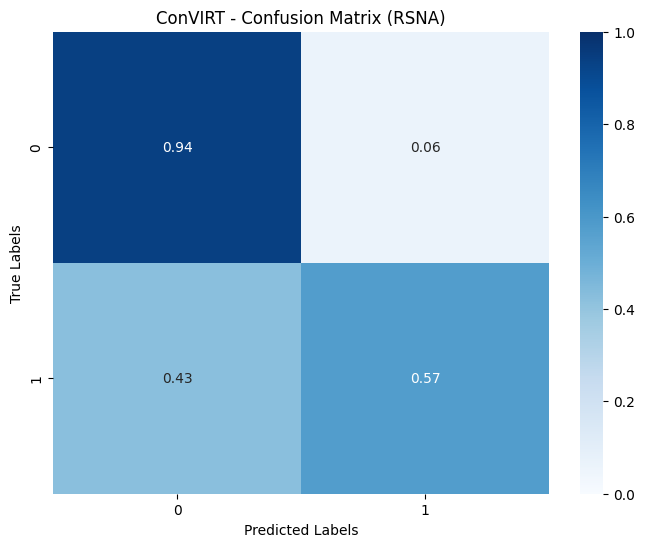

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def compute_and_plot_confusion_matrix(filename, method, path_to_save):
    validation_losses = []

    # Load JSON lines from the file
    with open(filename, "r") as f:
        for line in f:
            validation_losses.append(json.loads(line))

    # Convert to DataFrame
    df = pd.DataFrame(validation_losses)
    print(df.columns)  # Debugging step to check column names
    

    y_true = df['labels']
    y_pred = df['preds']
    
    report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
    print("Classification Report:")
    print(report)

    # Compute confusion matrix
    cm = confusion_matrix(df['labels'], df['preds'])

    # Normalize confusion matrix (relative values)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cmap = sns.color_palette(["#d0f0ff", "skyblue", "#187bcd"], as_cmap=True)
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap="Blues", 
                xticklabels=[0, 1], yticklabels=[0, 1], vmin=0, vmax=1)
    plt.title(f'{method} - Confusion Matrix (RSNA)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(path_to_save, format="png", dpi=300)
    plt.show()

# Call the function
compute_and_plot_confusion_matrix("test_losses_convirt.json", "ConVIRT", "ConVIRT_CM.png")

Index(['batch_idx', 'loss', 'preds', 'labels'], dtype='object')
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.80      0.81      0.80       997
     Class 1       0.80      0.80      0.80       991

    accuracy                           0.80      1988
   macro avg       0.80      0.80      0.80      1988
weighted avg       0.80      0.80      0.80      1988



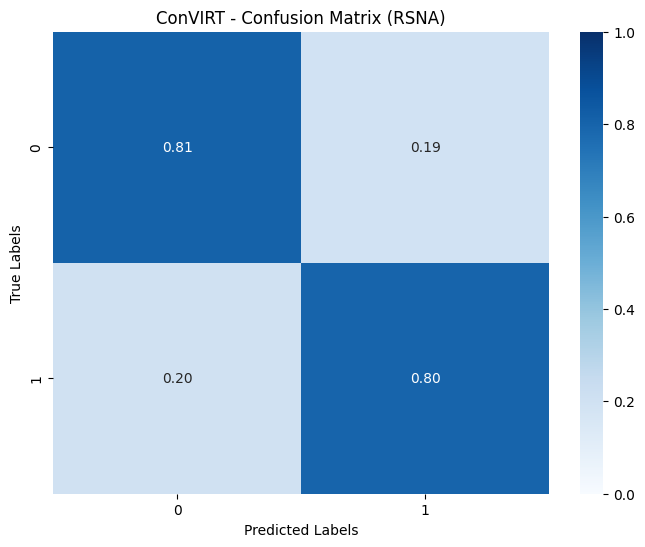

In [19]:
compute_and_plot_confusion_matrix("test_losses_convirt_balanced.json", "ConVIRT", "ConVIRT_CM_balanced.png")

Index(['batch_idx', 'loss', 'preds', 'labels'], dtype='object')
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.93      0.90      3081
     Class 1       0.71      0.58      0.64       922

    accuracy                           0.85      4003
   macro avg       0.79      0.75      0.77      4003
weighted avg       0.84      0.85      0.84      4003



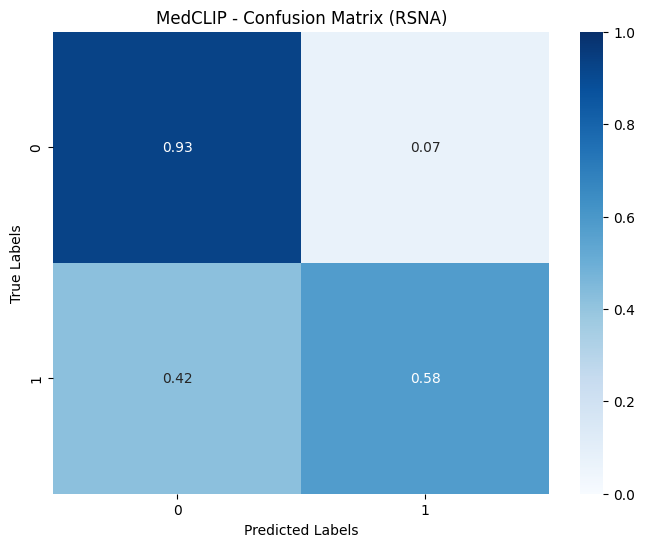

In [20]:
compute_and_plot_confusion_matrix("test_losses_medclip.json", "MedCLIP", "MedCLIP_CM.png")

Index(['batch_idx', 'loss', 'preds', 'labels'], dtype='object')
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.81      0.79      0.80       902
     Class 1       0.79      0.81      0.80       902

    accuracy                           0.80      1804
   macro avg       0.80      0.80      0.80      1804
weighted avg       0.80      0.80      0.80      1804



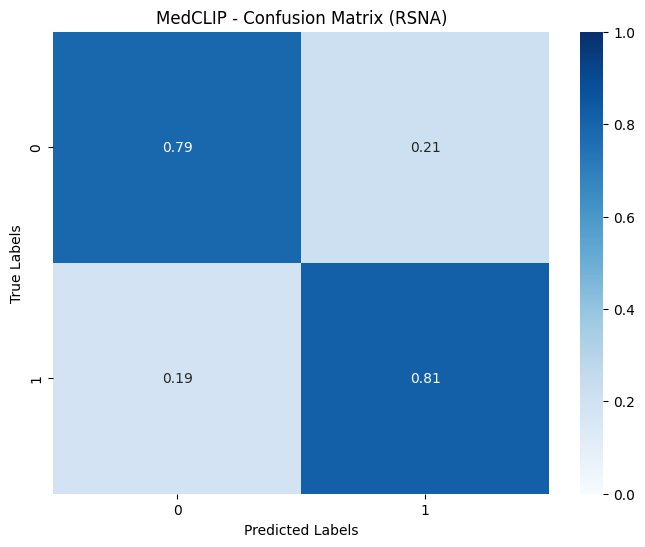

In [22]:
compute_and_plot_confusion_matrix("test_losses_medclip_balanced.json", "MedCLIP", "MedCLIP_CM_balanced.png")

In [6]:
df.columns

Index(['batch_idx', 'loss', 'preds', 'labels'], dtype='object')

In [3]:
df["labels"].value_counts()

labels
0.0    3081
1.0     922
Name: count, dtype: int64

In [4]:
df['preds'].value_counts()

preds
0    3289
1     714
Name: count, dtype: int64

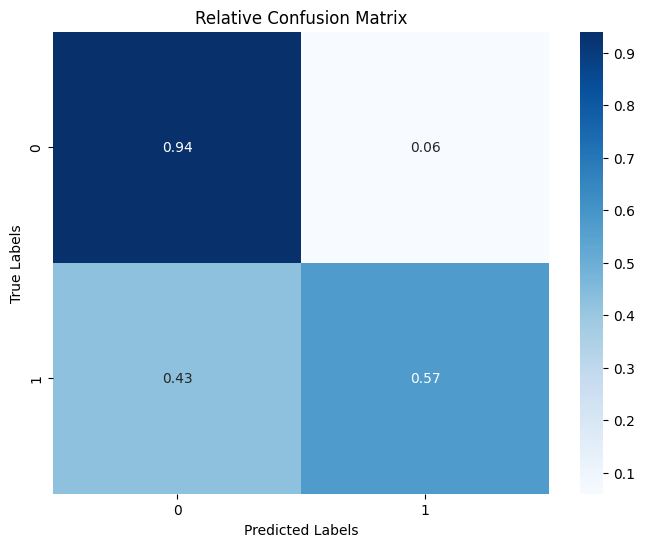

In [8]:
cm = confusion_matrix(df['labels'], df['preds'], labels=[0, 1])

# Normalize confusion matrix (relative values)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Relative Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [9]:
label_counts = df['labels'].value_counts()
label_percentages = df['labels'].value_counts(normalize=True) * 100

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labels in Test Dataset', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
for i, count in enumerate(label_counts.values):
    plt.text(i, count + 0.5, f'{count} ({label_percentages.iloc[i]:.2f}%)', ha='center', fontsize=12)
plt.show()

# Print numerical statistics
print("Label Distribution:")
print(label_counts)
print("\nPercentage Distribution:")
print(label_percentages)

NameError: name 'df' is not defined

In [18]:
## Train
import pandas as pd

path= "/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/VLP-Seminar/annotations/rsna/train.csv"

df_train = pd.read_csv(path)
df_train

path  \
0      /Users/sandradening/Documents/Dokumente_Sandra...   
1      /Users/sandradening/Documents/Dokumente_Sandra...   
2      /Users/sandradening/Documents/Dokumente_Sandra...   
3      /Users/sandradening/Documents/Dokumente_Sandra...   
4      /Users/sandradening/Documents/Dokumente_Sandra...   
...                                                  ...   
18673  /Users/sandradening/Documents/Dokumente_Sandra...   
18674  /Users/sandradening/Documents/Dokumente_Sandra...   
18675  /Users/sandradening/Documents/Dokumente_Sandra...   
18676  /Users/sandradening/Documents/Dokumente_Sandra...   
18677  /Users/sandradening/Documents/Dokumente_Sandra...   

                                  patientId  label  \
0      5b3477db-9494-4617-acac-e2f28452ebb0      0   
1      b6ebfc38-240b-4fac-ad09-ab378414fb55      1   
2      153b7c2b-4909-4dca-8579-9523582bc4fe      0   
3      75b6d578-16fa-4e46-afb3-aab78453382a      0   
4      1a7606e0-4d81-4bbe-ae22-93ca30540cb9      1   
...                                     ...    ...   
18673  89fe1bc2-7a5c-468f-8202-fef9fd13eba7      1   
18674  c37d38fe-a11e-453a-88a5-5d919bf9f760      1   
18675  6ccaed40-444e-43b9-ae7e-e66fdf41e082      0   
18676  74f8f310-cc0c-41ff-871d-8daadb81bbcd      0   
18677  2dff430f-e5e9-4d90-9139-14f64a68fb15      0   

                                                    bbox  
0                                 [[0.0, 0.0, 0.0, 0.0]]  
1      [[237.0, 639.0, 500.0, 836.0], [665.0, 631.0, ...  
2                                 [[0.0, 0.0, 0.0, 0.0]]  
3                                 [[0.0, 0.0, 0.0, 0.0]]  
4                         [[550.0, 451.0, 705.0, 599.0]]  
...                                                  ...  
18673                     [[278.0, 323.0, 418.0, 487.0]]  
18674  [[216.0, 424.0, 379.0, 837.0], [623.0, 297.0, ...  
18675                             [[0.0, 0.0, 0.0, 0.0]]  
18676                             [[0.0, 0.0, 0.0, 0.0]]  
18677                             [[0.0, 0.0, 0.0, 0.0]]  

[18678 rows x 4 columns]

In [28]:
def plot_dist(df):

    label_counts = df['label'].value_counts()
    label_percentages = df['label'].value_counts(normalize=True) * 100

    # Plot the distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
    plt.title('Distribution of Labels in Train Dataset', fontsize=16)
    plt.xlabel('Labels', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(ticks=[0, 1], labels=['Class 0', 'Class 1'])
    for i, count in enumerate(label_counts.values):
        plt.text(i, count + 0.5, f'{count} ({label_percentages.iloc[i]:.2f}%)', ha='center', fontsize=12)
    plt.show()

    # Print numerical statistics
    print("Label Distribution:")
    print(label_counts)
    print("\nPercentage Distribution:")
    print(label_percentages)

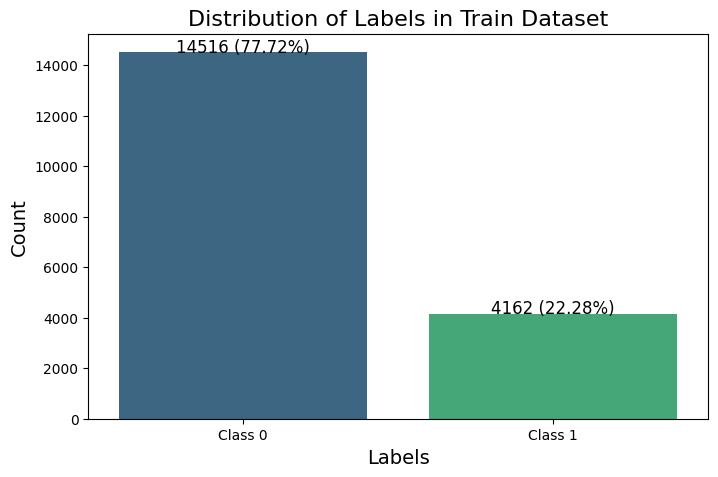

Label Distribution:
label
0    14516
1     4162
Name: count, dtype: int64

Percentage Distribution:
label
0    77.7171
1    22.2829
Name: proportion, dtype: float64


In [29]:
plot_dist(df_train)

In [26]:
path= "/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/VLP-Seminar/annotations/rsna/val.csv"

df_val = pd.read_csv(path)
df_val

path  \
0     /Users/sandradening/Documents/Dokumente_Sandra...   
1     /Users/sandradening/Documents/Dokumente_Sandra...   
2     /Users/sandradening/Documents/Dokumente_Sandra...   
3     /Users/sandradening/Documents/Dokumente_Sandra...   
4     /Users/sandradening/Documents/Dokumente_Sandra...   
...                                                 ...   
3998  /Users/sandradening/Documents/Dokumente_Sandra...   
3999  /Users/sandradening/Documents/Dokumente_Sandra...   
4000  /Users/sandradening/Documents/Dokumente_Sandra...   
4001  /Users/sandradening/Documents/Dokumente_Sandra...   
4002  /Users/sandradening/Documents/Dokumente_Sandra...   

                                 patientId  label  \
0     8e2001aa-2958-4e86-a73a-c3c1eeee00cd      0   
1     9d42ccce-13f6-4053-8597-988d3ca98b74      1   
2     8d420869-5632-4a1d-9b75-c913472148bf      0   
3     7add6f24-2117-4620-a180-ea3b1e6dbd1a      0   
4     835ea6ca-9564-41da-80de-568f18c82ab2      1   
...                                    ...    ...   
3998  eb34854c-a35d-4673-bb74-048f2e8e3217      0   
3999  097574ff-b999-4c5f-bb7a-3eee6fed02d1      0   
4000  9456860f-f6d8-4905-8ed7-a0e9debe8d99      0   
4001  98587034-db53-4cc8-893e-1c2a79088ab1      0   
4002  e5f18540-d691-47f7-abd3-f41d8d967e1e      0   

                                bbox  
0             [[0.0, 0.0, 0.0, 0.0]]  
1     [[561.0, 197.0, 799.0, 811.0]]  
2             [[0.0, 0.0, 0.0, 0.0]]  
3             [[0.0, 0.0, 0.0, 0.0]]  
4     [[584.0, 399.0, 834.0, 717.0]]  
...                              ...  
3998          [[0.0, 0.0, 0.0, 0.0]]  
3999          [[0.0, 0.0, 0.0, 0.0]]  
4000          [[0.0, 0.0, 0.0, 0.0]]  
4001          [[0.0, 0.0, 0.0, 0.0]]  
4002          [[0.0, 0.0, 0.0, 0.0]]  

[4003 rows x 4 columns]

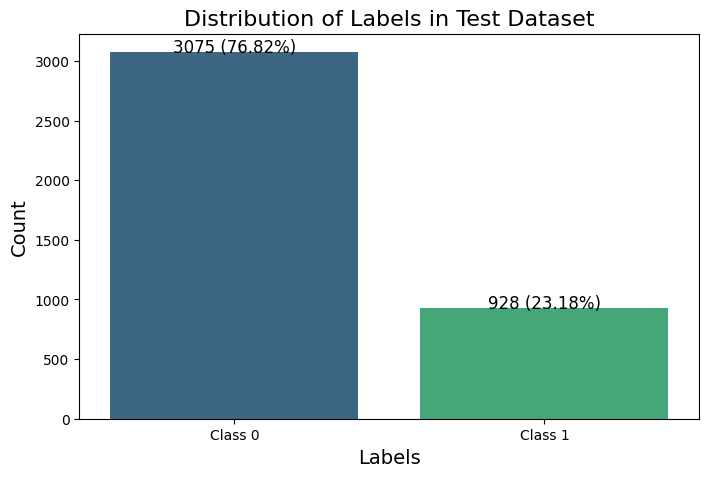

Label Distribution:
label
0    3075
1     928
Name: count, dtype: int64

Percentage Distribution:
label
0    76.817387
1    23.182613
Name: proportion, dtype: float64


In [27]:
plot_dist(df_val)

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.94      0.91      3081
     Class 1       0.74      0.57      0.65       922

    accuracy                           0.86      4003
   macro avg       0.81      0.76      0.78      4003
weighted avg       0.85      0.86      0.85      4003

Confusion Matrix:
[[2897  184]
 [ 392  530]]

Normalized Confusion Matrix:
[[0.94027913 0.05972087]
 [0.42516269 0.57483731]]


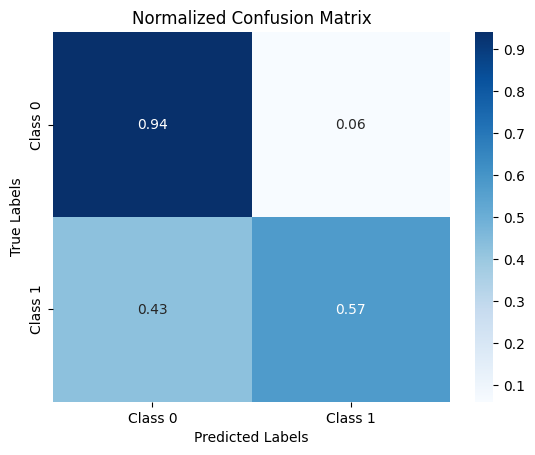

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
y_true = df['labels']
y_pred = df['preds']

# Classification Report (Precision, Recall, F1)
report = classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1'])
print("Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(cm_normalized)

# Plot confusion matrix if needed (from previous steps)
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

-> 42.52% of class 1 instances are missed (False Negatives), and 57.48% are correctly classified as class 1 (True Positives)

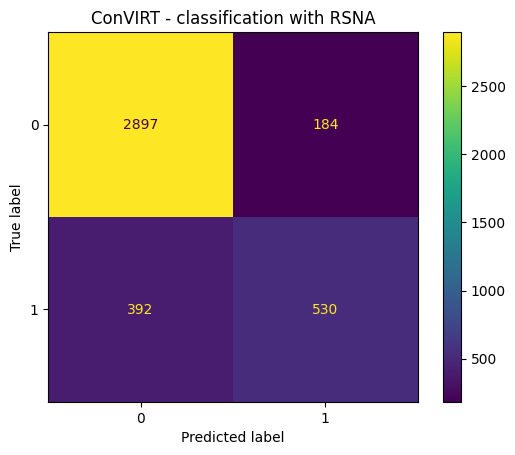

In [5]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(df['labels'], df['preds'])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.title('ConVIRT - classification with RSNA')
plt.show()

In [16]:
sorted_loss_df = df.sort_values(by="loss", ascending=False)
sorted_loss_df

batch_idx      loss  preds  labels
3728       3728  4.894003      0     1.0
153         153  4.713731      0     1.0
1217       1217  4.707642      0     1.0
1632       1632  4.428976      0     1.0
462         462  4.357889      0     1.0
...         ...       ...    ...     ...
3339       3339  0.002755      0     0.0
3150       3150  0.002608      0     0.0
3732       3732  0.002580      0     0.0
3140       3140  0.002540      0     0.0
2284       2284  0.002525      0     0.0

[4003 rows x 4 columns]

## Embeddings t-SNE plot

In [71]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/chexpert.yaml')

checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'
checkpoint = torch.load(checkpoint_path)
finetuned_convirt = FinetuneClassifier(config)
finetuned_convirt.load_state_dict(checkpoint['state_dict'])

Loading configuration from: ../configs/chexpert.yaml


FileNotFoundError: [Errno 2] No such file or directory: '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'

In [18]:
from datasets.cls_dataset import RSNAImageClsDataset, ChexPertImageClsDataset
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms

datamodule = DataModule(dataset=ChexPertImageClsDataset, 
                                config=config, collate_fn=None,
                                transforms=DataTransforms, data_pct=1,
                                batch_size=64, num_workers=16)

In [19]:
import torch
from methods.cls_model import FinetuneClassifier

def extract_embeddings(model, dataloader):
    model.eval()  # Ensure the model is in evaluation mode
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            feats, labels = model.shared_step(batch, return_embeddings=True)
            all_feats.append(feats.cpu())  # Move to CPU
            all_labels.append(labels.cpu())

    # Concatenate all features and labels
    all_feats = torch.cat(all_feats)
    all_labels = torch.cat(all_labels)
    return all_feats, all_labels

In [20]:
# Assuming you have a trained model and a Trainer instance
val_dataloader = datamodule.val_dataloader()  # Validation dataloader
val_feats, val_labels = extract_embeddings(finetuned_convirt, val_dataloader)
print(val_feats.shape)  # (num_samples, embedding_dim)
print(val_labels.shape) 

Dataset size of split valid: 4234
torch.Size([4224, 768])
torch.Size([4224, 5])


In [5]:
# Assuming you have a trained model and a Trainer instance
test_dataloader = datamodule.test_dataloader()  # Test dataloader
test_feats, test_labels = extract_embeddings(finetuned_convirt, test_dataloader)
print(test_feats.shape)  # (num_samples, embedding_dim)
print(test_labels.shape) 

Dataset size of split test: 202
torch.Size([202, 768])
torch.Size([202, 5])


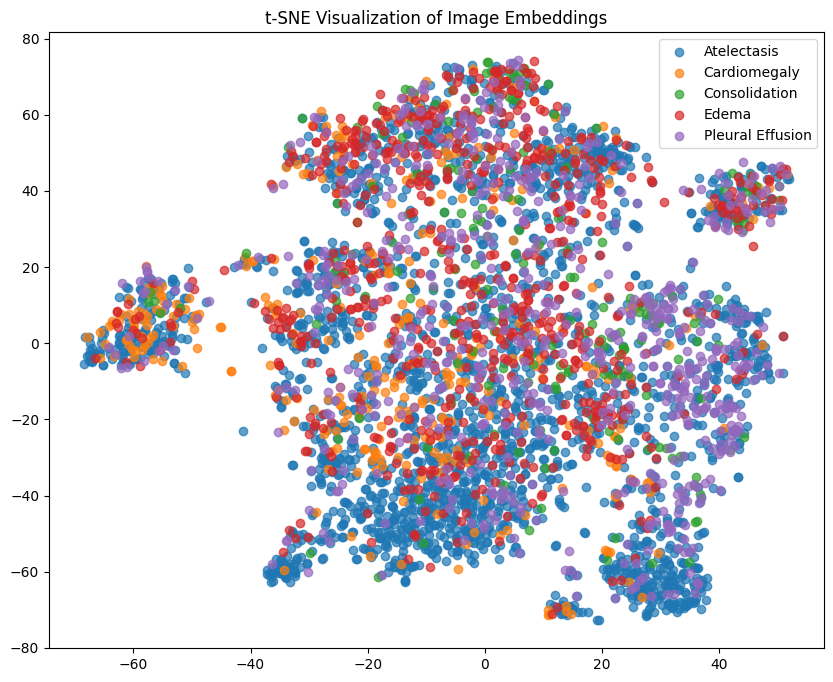

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = val_feats.numpy()
labels_np = val_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Visualize
def plot_embeddings(embeddings_2d, labels, class_names):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings(embeddings_2d, labels_np, class_names)


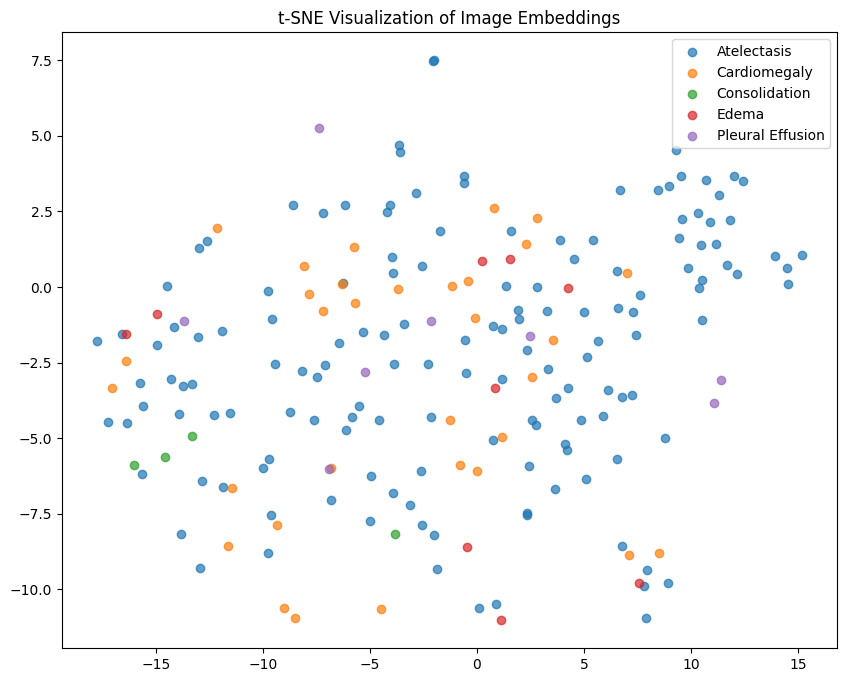

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = test_feats.numpy()
labels_np = test_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Visualize
def plot_embeddings(embeddings_2d, labels, class_names):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings(embeddings_2d, labels_np, class_names)

In [14]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/chexpert.yaml')

# checkpoint_path = '../data/ckpts/FinetuneCLS/chexpert/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'
# checkpoint = torch.load(checkpoint_path)
finetuned_imagenet = FinetuneClassifier(config)
# finetuned_convirt.load_state_dict(checkpoint['state_dict'])

In [15]:
# Assuming you have a trained model and a Trainer instance
val_dataloader = datamodule.val_dataloader()  # Validation dataloader
val_feats, val_labels = extract_embeddings(finetuned_imagenet, val_dataloader)
print(val_feats.shape)  # (num_samples, embedding_dim)
print(val_labels.shape) 

Dataset size of split valid: 4234
torch.Size([4224, 768])
torch.Size([4224, 5])


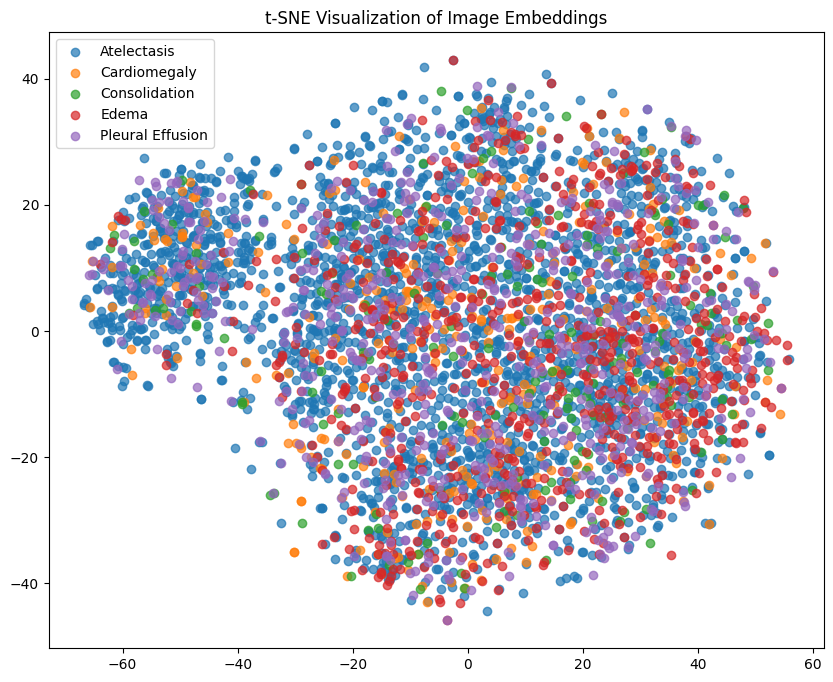

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = val_feats.numpy()
labels_np = val_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

# Visualize
def plot_embeddings(embeddings_2d, labels, class_names):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings(embeddings_2d, labels_np, class_names)

In [ ]:
# Sandra

In [18]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier
from datasets.cls_dataset import RSNAImageClsDataset, ChexPertImageClsDataset
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms
import torch
from methods.cls_model import FinetuneClassifier

config = load_config('../configs/rsna.yaml')

Loading configuration from: ../configs/rsna.yaml


In [19]:
checkpoint_path = '../data/ckpts/FinetuneCLS/rsna/2025_01_13_17_11_53/epoch=19-step=58039.ckpt'
checkpoint = torch.load(checkpoint_path)
finetuned_medCLIP = FinetuneClassifier(config)
finetuned_medCLIP.load_state_dict(checkpoint['state_dict'])

In [20]:
datamodule = DataModule(dataset=ChexPertImageClsDataset, 
                                config=config, collate_fn=None,
                                transforms=DataTransforms, data_pct=1,
                                batch_size=64, num_workers=16)
datamodule

In [21]:
def extract_embeddings(model, dataloader):
    model.eval()  # Ensure the model is in evaluation mode
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            feats, labels = model.shared_step(batch, return_embeddings=True)
            all_feats.append(feats.cpu())  # Move to CPU
            all_labels.append(labels.cpu())

    # Concatenate all features and labels
    all_feats = torch.cat(all_feats)
    all_labels = torch.cat(all_labels)
    return all_feats, all_labels

In [83]:
# Assuming you have a trained model and a Trainer instance
test_dataloader = datamodule.test_dataloader()  # Test dataloader
test_feats, test_labels = extract_embeddings(finetuned_medCLIP, test_dataloader)
print(test_feats.shape)  # (num_samples, embedding_dim)
print(test_labels.shape) 

Dataset size of split test: 202


TypeError: FinetuneClassifier.shared_step() got an unexpected keyword argument 'return_embeddings'

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Convert embeddings and labels to numpy arrays
embeddings_np = val_feats.numpy()
labels_np = val_labels.numpy()
if labels_np.ndim == 2:
        labels_np = np.argmax(labels_np, axis=1)  # Assign to the first active class

        
# Normalize embeddings
scaler = StandardScaler()
embeddings_np = scaler.fit_transform(embeddings_np)
    
        
# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

In [ ]:
# Visualize
def plot_embeddings(embeddings_2d, labels, class_names):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        idx = labels == class_idx
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title("t-SNE Visualization of Image Embeddings")
    plt.show()

class_names = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Pleural Effusion"]
plot_embeddings(embeddings_2d, labels_np, class_names)

# RSNA Image Embeddings

In [2]:
import pickle

In [4]:
import torch
from torchvision import transforms
from PIL import Image
import yaml
from train_cls import load_config
from methods.cls_model import FinetuneClassifier
from datasets.cls_dataset import RSNAImageClsDataset  # Using RSNA dataset now
from datasets.data_module import DataModule
from datasets.transforms import DataTransforms
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load config for RSNA dataset
config = load_config('../configs/rsna.yaml')

finetuned_rsna = FinetuneClassifier(config)


# Load trained RSNA model
checkpoint_path = '/Users/sandradening/Documents/Dokumente_Sandra/Master_Studium/3_Semester/VLM_Seminar/Code/data/ckpts/FinetuneCLS/rsna/2025_01_17_14_27_25/epoch=27-step=8147.ckpt'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict']

# Remove the keys corresponding to the extra layers
for key in list(state_dict.keys()):
    if "classification_head.block_forward.3" in key or "classification_head.block_forward.6" in key:
        state_dict.pop(key)

finetuned_rsna.load_state_dict(state_dict, strict=False)

Loading configuration from: ../configs/rsna.yaml


RuntimeError: Error(s) in loading state_dict for FinetuneClassifier:
	size mismatch for img_encoder_q.global_embed.head.0.weight: copying a param with shape torch.Size([2048, 2048]) from checkpoint, the shape in current model is torch.Size([2048, 768]).
	size mismatch for img_encoder_q.local_embed.head.0.weight: copying a param with shape torch.Size([2048, 1024, 1]) from checkpoint, the shape in current model is torch.Size([2048, 768, 1]).

In [15]:
# RSNA DataModule (binary classification task)
datamodule = DataModule(dataset=RSNAImageClsDataset, 
                        config=config, collate_fn=None,
                        transforms=DataTransforms, data_pct=1,
                        batch_size=64, num_workers=16)

In [22]:
# Extract embeddings function (same as before)
def extract_embeddings(model, dataloader):
    model.eval()  # Ensure the model is in evaluation mode
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            feats, labels = model.shared_step(batch, return_embeddings=True)
            all_feats.append(feats.cpu())  # Move to CPU
            all_labels.append(labels.cpu())

    # Concatenate all features and labels
    all_feats = torch.cat(all_feats)
    all_labels = torch.cat(all_labels)
    return all_feats, all_labels

In [16]:
# Extract embeddings from RSNA test data
test_dataloader = datamodule.test_dataloader()  # Test dataloader
test_feats, test_labels = extract_embeddings(finetuned_rsna, test_dataloader)
print(test_feats.shape)  # (num_samples, embedding_dim)
print(test_labels.shape)

Dataset size of split test: 4003
torch.Size([4003, 2048])
torch.Size([4003, 1])


In [26]:
with open('rsna_embeddings.pkl', 'rb') as f:
    embeddings_np, labels_np = pickle.load(f)

In [17]:
# Convert embeddings and labels to numpy arrays
#embeddings_np = test_feats.numpy()
#labels_np = test_labels.numpy()

# Normalize embeddings
scaler = StandardScaler()
embeddings_np = scaler.fit_transform(embeddings_np)

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

In [27]:
with open('rsna_embeddings_2d.pkl', 'wb') as f:
    pickle.dump((embeddings_np, labels_np, embeddings_2d), f)

In [3]:
import pickle

In [4]:
with open('rsna_embeddings_2d.pkl', 'rb') as f:
    embeddings_np, labels_np, embeddings_2d = pickle.load(f)

In [5]:
embeddings_2d

array([[  7.5346894, -20.223734 ],
       [ 20.48322  ,   9.7845545],
       [ 27.464273 ,  -2.7210052],
       ...,
       [-19.430914 ,   9.058196 ],
       [-19.423468 , -27.635513 ],
       [ 32.826073 ,  39.922184 ]], dtype=float32)

In [10]:
# Visualize the embeddings with t-SNE
def plot_embeddings(embeddings_2d, labels, class_names, title):
    plt.figure(figsize=(10, 8))
    for class_idx, class_name in enumerate(class_names):
        # Flatten the labels to ensure correct indexing
        idx = labels.ravel() == class_idx  # Make sure labels are 1D
        plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=class_name, alpha=0.7)
    plt.legend()
    plt.title(f"{title} - t-SNE Visualization of Image Embeddings")
    plt.show()

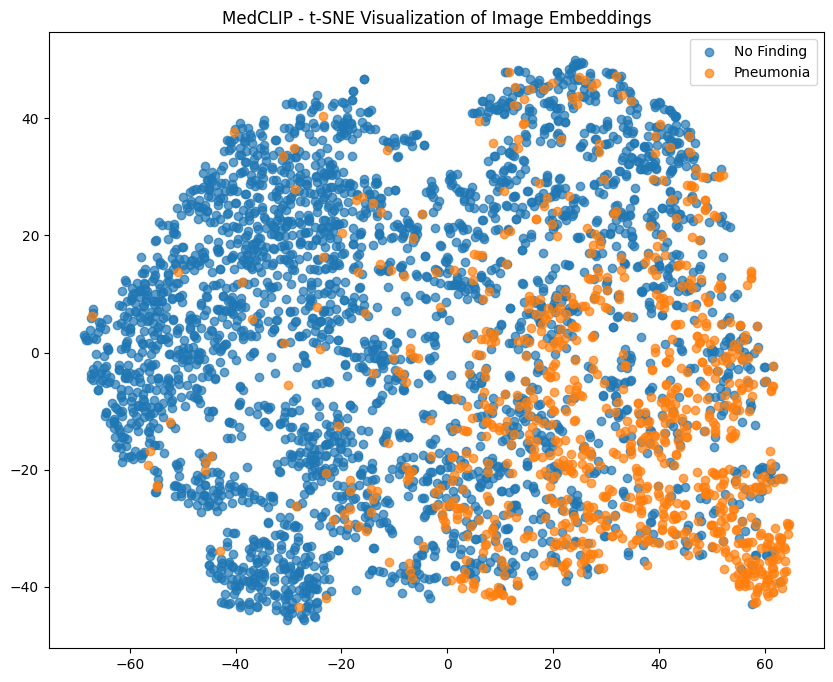

In [11]:
# Class names for binary classification in RSNA
class_names = ["No Finding", "Pneumonia"]  # Change based on your class names
plot_embeddings(embeddings_2d, labels_np, class_names, "MedCLIP")